# Part A is copied here and minimized

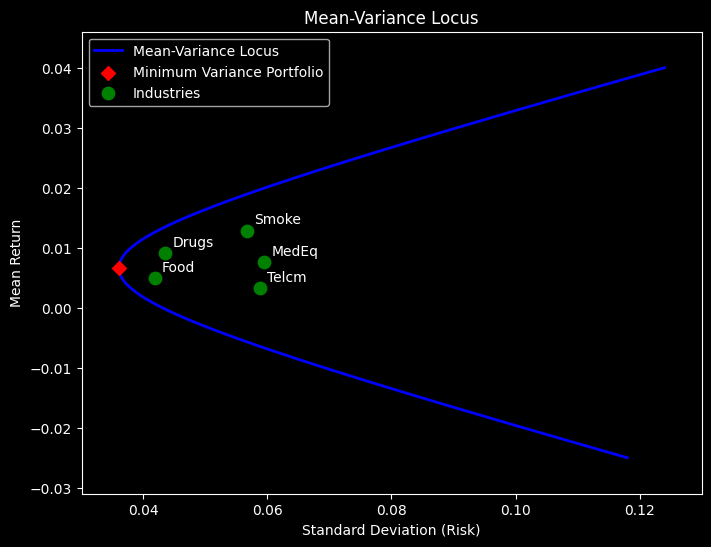

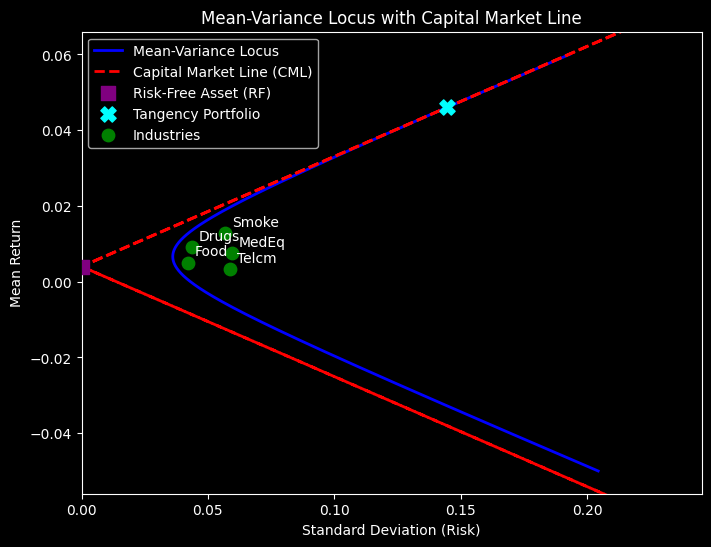


Tangency Portfolio Characteristics for Specified Graph:
    Characteristic    Value
   Expected Return 0.046030
          Variance 0.020911
Standard Deviation 0.144607

Tangency Portfolio Weights for Specified Graph:
         Weight
Food  -3.000123
Smoke  3.366369
MedEq  0.552711
Drugs  2.265163
Telcm -2.184119


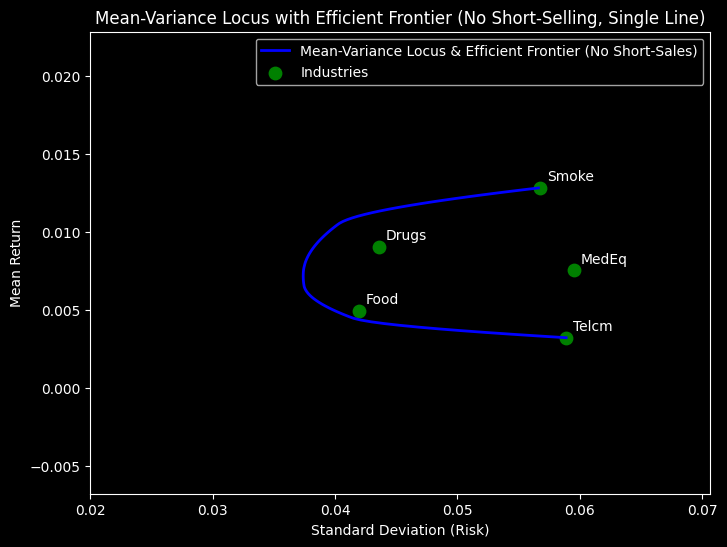

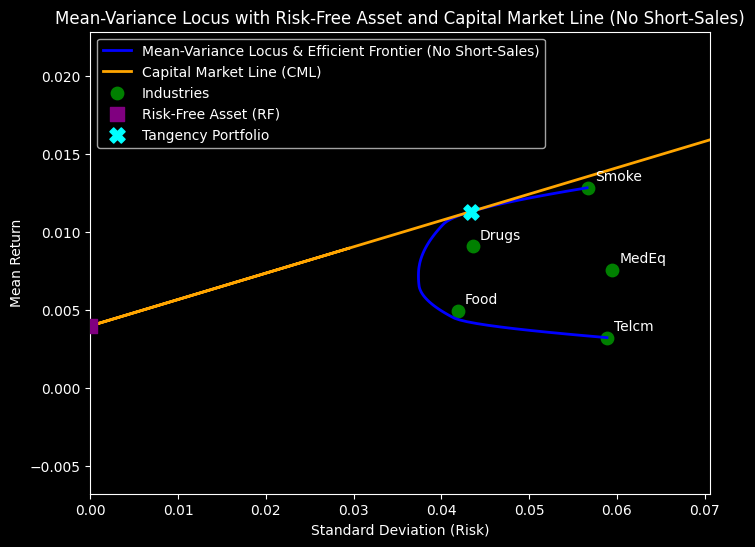


Tangency Portfolio Characteristics:
    Characteristic    Value
   Expected Return 0.011321
          Variance 0.001882
Standard Deviation 0.043377

Tangency Portfolio Weights:
         Weight
Food   0.000000
Smoke  0.592492
MedEq  0.000000
Drugs  0.407508
Telcm  0.000000


In [1]:
# %% [markdown]
# # Prepare Data

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load new dataset
file_path = "Returns_Data_Cleaned.csv"  # Updated file path
df = pd.read_csv(file_path)

# Rename the first column (date column) properly
df.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Filter for only the required industries
selected_industries = ["Food", "Smoke", "MedEq", "Drugs", "Telcm"]
df = df[["Dates"] + selected_industries]

# Convert Date column to DateTime format
df = df[df["Dates"].astype(str).str.match(r"^\d{6}$")]  # Keep only YYYYMM format
df["Dates"] = pd.to_datetime(df["Dates"], format="%Y%m")

# Filter data for the required date range
df_filtered = df[(df["Dates"] >= "2019-12-01") & (df["Dates"] <= "2024-11-01")]

# Convert returns from percentage format to decimal (divide by 100)
df_filtered.iloc[:, 1:] = df_filtered.iloc[:, 1:].div(100)

# Set Date as index
df_filtered.set_index("Dates", inplace=True)


# %% [markdown]
# # Part A

# %% [markdown]
# ## 1

# %%
# Step 1: Calculate the mean return for each column (Monthly Average Returns)
mean_returns = df_filtered.mean(axis=0)

# Recalculate monthly variance from the original dataset
monthly_variance = df_filtered.var(axis=0, ddof=1)

# Compute the standard deviation
monthly_std_dev = monthly_variance**0.5

# Step 2: Extract the sample covariance matrix (Σ) and the mean returns vector (μ)
cov_matrix = df_filtered.cov(ddof=1).values  # Covariance matrix Σ (sample statistics)
mean_returns_vector = mean_returns.values    # Vector of expected returns (μ)
ones_vector = np.ones(mean_returns_vector.shape)  # Vector of ones

# Step 3: Calculate A, B, C, and Δ (Delta) using sample statistics
inv_cov_matrix = np.linalg.inv(cov_matrix)     # Σ^-1 (inverse of covariance matrix)
A = ones_vector @ inv_cov_matrix @ ones_vector  # A = 1'Σ^-11
B = ones_vector @ inv_cov_matrix @ mean_returns_vector  # B = 1'Σ^-1μ
C = mean_returns_vector @ inv_cov_matrix @ mean_returns_vector  # C = μ'Σ^-1μ
Delta = (A * C) - (B ** 2)  # Δ = AC - B^2

# Step 4: Compute the Minimum Variance Portfolio (MVP)
mvp_weights = (inv_cov_matrix @ ones_vector) / A
mvp_return = np.dot(mvp_weights, mean_returns_vector)
mvp_std = np.sqrt(mvp_weights.T @ cov_matrix @ mvp_weights)  # Standard deviation of MVP

# Step 5: Define a range of portfolio returns (μ)
target_returns = np.linspace(-0.025, 0.04, 500)  # Independent range for μ (Y-axis values)

# Step 6: Compute λ and γ for the given μ values
lambda_values = (C - target_returns * B) / Delta
gamma_values = (target_returns * A - B) / Delta

# Step 7: Compute the portfolio variances (σ^2)
sigma_squared = []
for lam, gam in zip(lambda_values, gamma_values):
    # Compute weights: w = λ * Σ^-1 * 1 + γ * Σ^-1 * μ
    w = lam * (inv_cov_matrix @ ones_vector) + gam * (inv_cov_matrix @ mean_returns_vector)
    # Compute portfolio variance: σ^2 = w' Σ w
    sigma_squared.append(w.T @ cov_matrix @ w)

# Convert to NumPy array
sigma_squared = np.array(sigma_squared)
efficient_risks = np.sqrt(sigma_squared)  # Standard deviations (Risk)

# Identify the efficient part (upper part of the parabola)
efficient_idx = np.argmax(target_returns > mvp_return)  # Index where frontier becomes efficient
efficient_risks_upper = efficient_risks[efficient_idx:]
target_returns_upper = target_returns[efficient_idx:]

# Plot Mean-Variance Locus
plt.figure(figsize=(8, 6))

# Combined Mean-Variance Locus and Efficient Frontier (Single Formatted Line)
plt.plot(efficient_risks, target_returns, label="Mean-Variance Locus", color="blue", linewidth=2)

# Minimum Variance Portfolio (MVP)
plt.scatter(mvp_std, mvp_return, color="red", label="Minimum Variance Portfolio", zorder=3, marker="D", s=50)

# Industry points (Green Dots)
plt.scatter(monthly_std_dev, mean_returns, marker='o', color='green', label="Industries", s=80)

# Annotate each industry point
for industry, x, y in zip(df_filtered.columns, monthly_std_dev, mean_returns):
    plt.annotate(industry, (x, y), fontsize=10, xytext=(5, 5), textcoords="offset points")

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus")

# Expand axis limits for better visualization
plt.xlim(min(efficient_risks) - 0.006, max(efficient_risks) + 0.006)  # Expanded X range
plt.ylim(min(target_returns) - 0.006, max(target_returns) + 0.006)  # Expanded Y range

plt.legend()
plt.grid(False)

# Show the plot
plt.show()


# %% [markdown]
# ## 2

# %%
# Define the risk-free rate (0.4% per month)
rf = 0.004  

# Compute the inverse of the covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute the excess returns (mean returns - risk-free rate)
excess_returns = mean_returns - rf

# Compute the tangency portfolio weights
tangency_weights = inv_cov_matrix @ excess_returns / (ones_vector @ inv_cov_matrix @ excess_returns)

# Compute the expected return and standard deviation of the tangency portfolio
tangency_return = np.dot(tangency_weights, mean_returns)
tangency_std = np.sqrt(tangency_weights.T @ cov_matrix @ tangency_weights)

# Define a range of portfolio returns for the Mean-Variance Locus
target_returns = np.linspace(-0.05, 0.06, 500)

# Compute λ and γ for the given μ values
lambda_values = (C - target_returns * B) / Delta
gamma_values = (target_returns * A - B) / Delta

# Compute the portfolio variances (σ^2)
sigma_squared = []
for lam, gam in zip(lambda_values, gamma_values):
    w = lam * (inv_cov_matrix @ ones_vector) + gam * (inv_cov_matrix @ mean_returns_vector)
    sigma_squared.append(w.T @ cov_matrix @ w)

# Convert to NumPy array
sigma_squared = np.array(sigma_squared)
efficient_risks = np.sqrt(sigma_squared)  # Standard deviations (Risk)

# Define the Capital Market Line (CML) symmetrically in both directions
cml_risks = np.linspace(-max(efficient_risks) * 1.5, max(efficient_risks) * 1.5, 300)
cml_risks = np.abs(cml_risks)  # Ensure standard deviation remains positive
cml_returns = rf + ((tangency_return - rf) / tangency_std) * np.concatenate((-cml_risks[::-1], cml_risks))

# Plot Mean-Variance Locus With Risk-Free Asset
plt.figure(figsize=(8, 6))

# Plot Mean-Variance Locus as a Single Line
plt.plot(efficient_risks, target_returns, label="Mean-Variance Locus", color='blue', linewidth=2)

# Plot the Capital Market Line (CML) extended symmetrically
plt.plot(np.concatenate((cml_risks[::-1], cml_risks)), cml_returns, label="Capital Market Line (CML)", linestyle="--", color="red", linewidth=2)

# Plot risk-free asset and tangency portfolio
plt.scatter(0, rf, color="purple", label="Risk-Free Asset (RF)", zorder=3, marker="s", s=100)
plt.scatter(tangency_std, tangency_return, color="cyan", label="Tangency Portfolio", zorder=3, marker="X", s=120)

# Industry points (Green Dots)
plt.scatter(monthly_std_dev, mean_returns, marker='o', color='green', label="Industries", s=80)

# Annotate each industry point
for industry, x, y in zip(df_filtered.columns, monthly_std_dev, mean_returns):
    plt.annotate(industry, (x, y), fontsize=10, xytext=(5, 5), textcoords="offset points")

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Capital Market Line")

# Expand axis limits for better visualization
plt.xlim(0, max(efficient_risks) * 1.2)  # Ensure positive risk range
plt.ylim(min(target_returns) - 0.006, max(target_returns) + 0.006)  # Properly centered Y range

plt.legend()
plt.grid(False)

# Show the plot
plt.show()


# %% [markdown]
# ## 3

# %%
# Compute the Tangency Portfolio characteristics with 6 decimal places for the specified graph
tangency_expected_return = round(tangency_return, 6)  # Expected return of the Tangency Portfolio
tangency_variance = round(tangency_std ** 2, 6)  # Variance of the Tangency Portfolio
tangency_std_rounded = round(tangency_std, 6)  # Standard Deviation of the Tangency Portfolio

# Create a DataFrame for Tangency Portfolio characteristics
tangency_portfolio_info = pd.DataFrame({
    "Characteristic": ["Expected Return", "Variance", "Standard Deviation"],
    "Value": [tangency_expected_return, tangency_variance, tangency_std_rounded]
})

# Create a DataFrame for Tangency Portfolio Weights with 6 decimal places
tangency_weights_df = pd.DataFrame(tangency_weights, index=mean_returns.index, columns=["Weight"])
tangency_weights_df = tangency_weights_df.round(6)

# Display the Tangency Portfolio characteristics and weights
print("\nTangency Portfolio Characteristics for Specified Graph:")
print(tangency_portfolio_info.to_string(index=False))

print("\nTangency Portfolio Weights for Specified Graph:")
print(tangency_weights_df.to_string())

# %% [markdown]
# ## 4

# %%
# Ensure num_assets is defined
num_assets = len(mean_returns)

# Function to calculate portfolio volatility
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Compute the Minimum Variance Portfolio (MVP)
ones_vector = np.ones(num_assets)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mvp_weights = (inv_cov_matrix @ ones_vector) / (ones_vector.T @ inv_cov_matrix @ ones_vector)
min_var_return = np.dot(mvp_weights, mean_returns)  # Define min_var_return
min_var_std = np.sqrt(mvp_weights.T @ cov_matrix @ mvp_weights)  # Compute min variance risk

# Modify the efficient frontier to include short-sale constraints (weights must be non-negative)
bounds = [(0, 1)] * num_assets  # No short-selling allowed

# Generate efficient frontier with short-sale constraints
target_returns_no_short = np.linspace(min(mean_returns) - 0, max(mean_returns) + 0.012857, 200)
efficient_risks_no_short = []

for target in target_returns_no_short:
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target})

    init_guess = np.ones(num_assets) / num_assets  # Ensure initial weights sum to 1

    result = minimize(portfolio_volatility, init_guess, args=(cov_matrix,), method='SLSQP',
                      constraints=constraints, bounds=bounds)

    efficient_risks_no_short.append(result.fun)

# Identify the efficient part (upper part of the parabola)
efficient_idx_no_short = np.argmax(target_returns_no_short > min_var_return)  # Index where frontier becomes efficient
efficient_risks_upper_no_short = efficient_risks_no_short[efficient_idx_no_short:]
target_returns_upper_no_short = target_returns_no_short[efficient_idx_no_short:]

# Define the cutoff points for the efficient frontier and mean-variance locus
max_return_limit = max(mean_returns["Smoke"], mean_returns["Telcm"])

# Filter the efficient frontier data to stop at the maximum return limit
valid_indices = target_returns_no_short <= max_return_limit
efficient_risks_no_short_limited = np.array(efficient_risks_no_short)[valid_indices]
target_returns_no_short_limited = np.array(target_returns_no_short)[valid_indices]

# Find the new efficient frontier part (upper portion)
efficient_idx_no_short_limited = np.argmax(target_returns_no_short_limited > min_var_return)
efficient_risks_upper_no_short_limited = efficient_risks_no_short_limited[efficient_idx_no_short_limited:]
target_returns_upper_no_short_limited = target_returns_no_short_limited[efficient_idx_no_short_limited:]

# Ensure standard deviations and mean returns have the same size
industry_std_no_short = df_filtered.std()[mean_returns.index]

# Plot the adjusted mean-variance locus with short-sale constraints as a single line
plt.figure(figsize=(8, 6))

# Combined Mean-Variance Locus and Efficient Frontier (Single Line)
plt.plot(efficient_risks_no_short_limited, target_returns_no_short_limited, 
         label="Mean-Variance Locus & Efficient Frontier (No Short-Sales)", color="blue", linewidth=2)

# Industry points (Green Dots)
plt.scatter(industry_std_no_short, mean_returns, marker='o', color='green', label="Industries", s=80)

# Annotate each industry point correctly
for industry, x, y in zip(mean_returns.index, industry_std_no_short, mean_returns):
    plt.annotate(industry, (x, y), fontsize=10, xytext=(5, 5), textcoords="offset points")

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Efficient Frontier (No Short-Selling, Single Line)")

# Adjust axis limits to properly align the graph
plt.xlim(0.02, max(efficient_risks_no_short_limited) * 1.2)  # Ensuring standard deviation remains positive
plt.ylim(min(target_returns_no_short_limited) - 0.01, max_return_limit + 0.01)  # Properly centered Y range

plt.legend()
plt.grid(False)

# Show the corrected plot
plt.show()

# %% [markdown]
# ## 5

# %%
# Function to calculate portfolio volatility
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Adjust mean returns to be in excess return form (subtract risk-free rate)
mean_returns_excess = mean_returns - rf

# Generate efficient frontier with short-sale constraints in excess return form
target_returns_no_short_rf = np.linspace(min(mean_returns_excess), max(mean_returns_excess) + 0.012857, 200)
efficient_risks_no_short_rf = []

# Solve for each target return in excess return space
for target in target_returns_no_short_rf:
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns_excess) - target}]

    result = minimize(lambda w: portfolio_volatility(w, cov_matrix), init_guess, method='SLSQP',
                      constraints=constraints, bounds=bounds)

    if result.success:
        efficient_risks_no_short_rf.append(result.fun)
    else:
        efficient_risks_no_short_rf.append(np.nan)  # Replace failed optimizations with NaN

# Convert lists to numpy arrays and filter out NaN values
efficient_risks_no_short_rf = np.array(efficient_risks_no_short_rf)
target_returns_no_short_rf = np.array(target_returns_no_short_rf)

valid_indices_rf = ~np.isnan(efficient_risks_no_short_rf)
efficient_risks_no_short_rf = efficient_risks_no_short_rf[valid_indices_rf]
target_returns_no_short_rf = target_returns_no_short_rf[valid_indices_rf]

# Define the cutoff points for the efficient frontier
max_return_limit_rf = max(mean_returns_excess["Smoke"], mean_returns_excess["Telcm"])

# Filter the efficient frontier data to stop at the maximum return limit
valid_indices_rf = target_returns_no_short_rf <= max_return_limit_rf
efficient_risks_no_short_limited_rf = efficient_risks_no_short_rf[valid_indices_rf]
target_returns_no_short_limited_rf = target_returns_no_short_rf[valid_indices_rf]

# Ensure standard deviations and mean returns have the same size
industry_std_no_short_rf = df_filtered.std()[mean_returns.index]

# Compute the Tangency Portfolio using the Sharpe Ratio maximization
def objective_sharpe(w, mean_returns, cov_matrix, rf):
    portfolio_return = np.dot(w, mean_returns)  # Portfolio expected return (absolute return)
    portfolio_volatility = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))  # Portfolio risk (volatility)
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility  # Sharpe ratio
    return -sharpe_ratio  # Maximize Sharpe Ratio by minimizing its negative

# Constraint: sum of weights = 1
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

# Optimize for the tangency portfolio weights
result_tangency = minimize(objective_sharpe, init_guess, args=(mean_returns, cov_matrix, rf), 
                           bounds=bounds, constraints=constraints)

# Extract optimal weights and compute tangency portfolio return and risk
if result_tangency.success:
    optimal_weights = result_tangency.x
    tangency_return = np.dot(optimal_weights, mean_returns)  # Tangency Portfolio return (absolute return)
    tangency_std = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))  # Tangency Portfolio risk

# Generate the extended Capital Market Line (CML)
cml_risk = np.linspace(-max(efficient_risks_no_short_limited_rf) * 0.5, max(efficient_risks_no_short_limited_rf) * 1.5, 300)  
cml_risk = np.abs(cml_risk)  # Ensure standard deviation remains positive
cml_return = rf + ((tangency_return - rf) / tangency_std) * cml_risk  # CML equation with correct RF intercept

# Plot Mean-Variance Locus with Risk-Free Asset (No Short-Sales) and Extended CML
plt.figure(figsize=(8, 6))

# Combined Mean-Variance Locus and Efficient Frontier (Single Line with RF Adjustment)
plt.plot(efficient_risks_no_short_limited_rf, target_returns_no_short_limited_rf + rf, 
         label="Mean-Variance Locus & Efficient Frontier (No Short-Sales)", color="blue", linewidth=2)

# Capital Market Line (CML) fully extended
plt.plot(cml_risk, cml_return, label="Capital Market Line (CML)", color="orange", linewidth=2)

# Industry points (Green Dots) in absolute return form
plt.scatter(industry_std_no_short_rf, mean_returns, marker='o', color='green', label="Industries", s=80)

# Annotate each industry point correctly
for industry, x, y in zip(mean_returns.index, industry_std_no_short_rf, mean_returns):
    plt.annotate(industry, (x, y), fontsize=10, xytext=(5,5), textcoords="offset points")

# Plot Risk-Free Asset at (0, RF) instead of (0,0)
plt.scatter(0, rf, color="purple", label="Risk-Free Asset (RF)", zorder=3, marker="s", s=100)

# Plot Tangency Portfolio at the optimal risk-return tradeoff
plt.scatter(tangency_std, tangency_return, color="cyan", label="Tangency Portfolio", zorder=3, marker="X", s=120)

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Risk-Free Asset and Capital Market Line (No Short-Sales)")

# Adjust axis limits for proper visualization
plt.xlim(0, max(efficient_risks_no_short_limited_rf) * 1.2)  # Ensuring standard deviation remains positive
plt.ylim(min(target_returns_no_short_limited_rf) + rf - 0.01, max(target_returns_no_short_limited_rf) + rf + 0.01)  # Properly centered Y range

plt.legend()
plt.grid(False)

# Show the corrected plot
plt.show()


# %% [markdown]
# ## 6

# %%
# Compute the Tangency Portfolio characteristics with 6 decimal places
tangency_expected_return = round(tangency_return, 6)  # Expected return of the Tangency Portfolio
tangency_variance = round(tangency_std ** 2, 6)  # Variance of the Tangency Portfolio
tangency_std_rounded = round(tangency_std, 6)  # Standard Deviation of the Tangency Portfolio

# Create a DataFrame for Tangency Portfolio characteristics
tangency_portfolio_info = pd.DataFrame({
    "Characteristic": ["Expected Return", "Variance", "Standard Deviation"],
    "Value": [tangency_expected_return, tangency_variance, tangency_std_rounded]
})

# Create a DataFrame for Tangency Portfolio Weights with 6 decimal places
tangency_weights_df = pd.DataFrame(optimal_weights, index=mean_returns.index, columns=["Weight"])
tangency_weights_df = tangency_weights_df.round(6)

# Display the Tangency Portfolio characteristics and weights
print("\nTangency Portfolio Characteristics:")
print(tangency_portfolio_info.to_string(index=False))

print("\nTangency Portfolio Weights:")
print(tangency_weights_df.to_string())

# %% [markdown]
# # Part B

# %% [markdown]
# 




# Start Here